<a href="https://colab.research.google.com/github/Firojpaudel/Machine-Learning-Notes/blob/main/Practical%20Deep%20Learning%20For%20Coders/Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification

In [ ]:
#@ Setting up the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


In [ ]:
#@ All libraries here:
from fastbook import *
from fastai.vision import *

Okay, now that I have initialized the setup, starting the chapter from here onwards...

In [ ]:
#@ Retrieving the data of the cats and dogs.
path = untar_data(URLs.PETS)

In [ ]:
#@ Inspecting the path
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
(path/'annotations').ls()       #@ We dont need this

(#7) [Path('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/README'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt')]

In [ ]:
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_46.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_188.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_151.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_136.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_37.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_134.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_16.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_167.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_143.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_14.jpg')...]

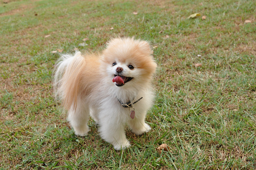

In [ ]:
#@ Checking one of them
img = Image.open(path/'images/pomeranian_109.jpg')
img.thumbnail((256,256))
img

In [ ]:
##@ Now, extracting the name of dog breed using regex
fname = (path/'images').ls()[0]
print("Without regex fname: ",fname)
#@ applying the regex
print("Now after regex, we get:")
re.findall(r"(.+)_\d+.jpg$", fname.name)

Without regex fname:  /root/.fastai/data/oxford-iiit-pet/images/saint_bernard_46.jpg
Now after regex, we get:


['saint_bernard']

<details>
  <summary>
    <b>
      Breakdown of the regex code
    </b>
  </summary>
  <ul>
    <li>
      <code>re.findall</code> function searches for all occurrences of the pattern in a string and returns them as a list.
    </li>
    <li>
      <code>r"(.+)_\d+.jpg$</code> is the expression that is being searched. Breaking this part even further:
      <ul>
        <li>
          <code>(.+)</code>: This captures one or more of any character (except newline) and stores it in a group.
        </li>
        <li>
          <code>_</code>: This matches the underscore character.
        </li>
        <li>
          <code>\d+</code>: This matches one or more digits
        </li>
        <li>
          <code>.jpg</code>: This matches the literal string ".jpg".
        </li>
        <li>
          <code>$</code>: This asserts the position at the end of the string.
        </li>
      </ul>
    </li>
    <li>
      <code>fname.name</code>: This is the string being searched, which is presumably the name of the file
    </li>
  </ul>
So, this code finds all the file names that match the pattern <code>something_digits.jpg</code> and captures the "something" part. For exmaple: if <code>fname.name</code> is <code>"image_123.jpg"</code>, the result would be <code>["image"]</code>.
</details>

In [ ]:
#@ Testing further more with regex:
re.findall(r"(.+)", fname.name)           ## Captures the entire string in fname.name

['saint_bernard_46.jpg']

In [ ]:
re.findall(r"(.+)_", fname.name)        ## Captures any sequence of characters until it encounters an underscore

['saint_bernard']

In [ ]:
re.findall(r"(.+)\d+", fname.name)     ## This is termed as greedy matching.

['saint_bernard_4']

In [ ]:
re.findall(r"(.+_\d+)", fname.name)       ## Since all of them are inside the parenthesis, it starts matching every characters, _ and digits are displayed

['saint_bernard_46']

**Greedy Matching**

---
The ```(.+)``` part in the regex code included above is the greedy matcher. Meaning it tries to match as much as possible while still allowing for the ```\d+``` part to match.

1. Why it stopped at ```pomeranian_10```?
    - The greedy matcher ```(.+)``` tries to match as much as possible while still allowing for the ```\d+``` part to match. It stops at ```pomeranian_10``` because it matches the entire string up to the last underscore before. It's more like leaving at least one digit to spare so that it satisfies the condition.

There is still a lot more to regex, but this much of regex would basically get the job done.

## Initializing datablock and dataloaders

Now that we have confirmed the regular expression, we can apply it to label the dataset using ```RegexLabeller``` within fastai's DataBlock API.

In [ ]:
##@ Initializing datablock:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),                        # Initializing DataBlock.
                 get_items=get_image_files,                                 # Getting Image Files.
                 splitter=RandomSplitter(seed=42),                          # Getting Random Splitting of Dataset.
                 get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"),"name"),  # Getting Labels.
                 item_tfms=Resize(460),                                     # Resizing Images.
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))       # Batch Augmentation.

##@ Initializing dataloaders:
dls = pets.dataloaders(path/"images")

**The purpose of ```RegexLabeller```:**

---
Using ```RegexLabeller``` automates label extraction, making it easy to generalize across many files without manual naming.

### Data Augmentation and Presizing in fastai

#### DataBlock Augmentation Configuration

- ```item_tfms``` and ```batch_tfms``` are the main augmentation parameters in DataBlock.
  - ```item_tfms=Resize(460)``` resizes each image to a large size (460px) before batch augmentation.
  - ```batch_tfms=aug_transforms(size=224, min_scale=0.75)``` applies random resizing and other transformations at the batch level on the GPU.

#### Presizing Strategy

- **Purpose:** Presizing ensures consistent image dimensions and minimizes computational load by combining transformations.
    - **Step 1:** Resize images to a large size (e.g., 460px), maintaining enough margin for further augmentation without introducing empty zones.
    - **Step 2:** Apply all augmentations (e.g., random crop, resize to final model size) in one GPU operation, reducing lossy transformations and maintaining image quality.

#### Common Presizing Challenges

- Direct resizing can cause quality loss in rotated or zoomed images due to repeated interpolation.
- Fastai’s presizing combines augmentation and resizing into a single operation, applied only once, which preserves more of the original data quality.

### Checking and Debugging the DataBlock

#### Inspecting Data with ```show_batch()```

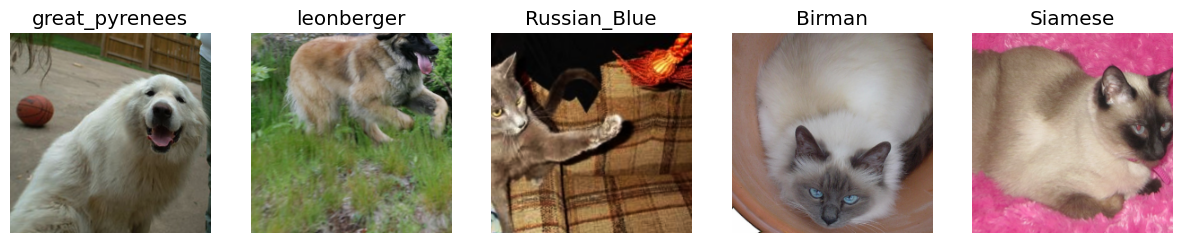

In [ ]:
dls.show_batch(nrows=1, ncols=5)

#### Debugging DataBlock Construction with ```summary()```

- Use ```summary()``` to diagnose errors in the DataBlock pipeline. It will simulate the data pipeline and report on each step.

In [ ]:
##@ Checking and debugging the datablock:
pets1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(seed=42),
                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                  item_tfms= Resize(460)) #Adding resize to ensure consistent large dimensions


pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_92.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_92.jpg
    applying partial gives
      german_shorthaired
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(20)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(20))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': Fals

### Training a Simple Model for Baseline Performance

#### Setting up a Simple Model

- Start with a simple model to gauge data suitability and establish a baseline.
- In fastai, use ```cnn_learner``` with ResNet34 and error rate as the evaluation metric:

In [ ]:
##@ Training the model:
learn= cnn_learner(dls, resnet34, metrics= error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 84.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.530138,0.327158,0.110961,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.490297,0.261752,0.089310,01:14
1,0.325955,0.216153,0.068336,01:17


<details>
<summary>
<b>Purpose of Early Testing</b></summary>

Early testing reveals if the data can train a model effectively, avoiding over-complicated preprocessing for straightforward problems.

</details>

Well we didn't specify the loss function we wanted to use. Fastai generally tries to select an appropriate loss function based on kind of data and model we are using.

In this case, we have image data and categorical output. So fastai will by default use **cross-entropy loss**.

### Cross- Entropy Loss

<details>
<summary>
  <b>Purpose of Early Testing:</b>
</summary>
Early testing reveals if the data can train a model effectively, avoiding over-complicated preprocessing for straightforward problems.

</details>


<details>
<summary><b>Cross-Entropy Loss is useful for:</b></summary>

  - Handling dependent variables with multiple categories.
  - Enabling faster and more reliable training.

To understand cross-entropy loss, we need to explore how activations and labels interact in multi-category classifications.

</details>

**Viewing Activations and Labels**

---

- **Getting a batch:** Use `dls.one_batch()` to access a batch of data, where:
  - `x, y = dls.one_batch()` returns independent (`x`) and dependent (`y`) variables.
- Example for `y` with 64 rows:

In [ ]:
x,y = dls.one_batch()

In [ ]:
y

TensorCategory([ 6, 27, 19, 23, 33, 29,  2,  0, 21, 35, 34, 32, 10,  0, 35, 16, 21, 15, 12, 15, 18, 28,  8,  1,  9,  4, 32, 21, 20, 34, 34, 12, 33,  0, 24,  4, 17, 11,  1, 25, 27, 15, 13, 21,  0, 25,
                13, 19, 23,  5, 27, 18, 36,  1, 29, 34, 16,  2, 23,  6,  8,  6, 13, 20], device='cuda:0')

Each row contains an integer representing one of 37 possible classes (e.g., pet breeds).

In [ ]:
##@ Predictions
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([2.7861e-06, 1.4225e-05, 3.1562e-05, 2.3020e-07, 6.3440e-06, 2.9698e-06, 9.9955e-01, 4.4932e-05, 3.1871e-04, 2.1333e-07, 1.0070e-06, 3.5638e-07, 6.1885e-07, 3.7041e-07, 1.3973e-08, 8.0072e-07,
        3.8021e-09, 6.2057e-08, 1.1433e-06, 8.0513e-07, 2.8361e-07, 1.4371e-06, 2.5746e-06, 2.6995e-06, 5.0081e-08, 3.0772e-06, 2.8836e-08, 2.5333e-06, 2.5643e-07, 1.1458e-07, 2.1590e-06, 2.4558e-07,
        6.1100e-08, 3.5330e-08, 3.2136e-08, 9.0012e-07, 1.6975e-06])

So, we get the probabilities for all 37 classes which when summed result to 1.

In [ ]:
preds[0].sum()

tensor(1.)

### Softmax Activation Function

Softmax ensures all activations:
- are between 0 to 1
- sum up to 1 across categories

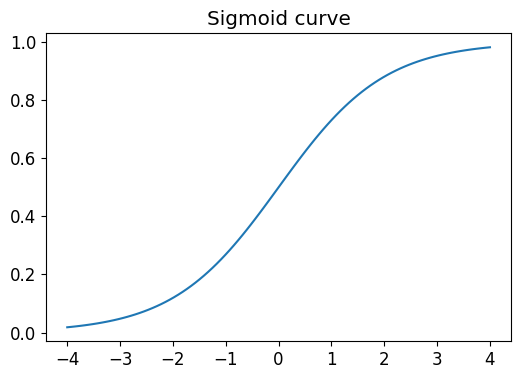

In [ ]:
##@ Plotting the graph of softmax function:
plot_function(torch.sigmoid, title="Sigmoid curve", min=-4, max= 4)

In [ ]:
##@ Using softmax for 2 or more than 2 categories
def softmax(x):
  return exp(x) / exp(x).sum(dim=1, keepdim= True)

#### Comparison with ```sigmoid```



























In [ ]:
#@ Creating random tensor:
acts = torch.randn((6,2))*2
acts

tensor([[-2.7469,  1.2929],
        [-3.3264, -0.6674],
        [-1.2777,  1.2582],
        [ 1.1777,  2.5570],
        [-1.6045, -3.3076],
        [ 2.2148, -2.0914]])

In [ ]:
##@ For binary:
(acts[:, 0]- acts[:,1]).sigmoid()

tensor([0.0173, 0.0654, 0.0734, 0.2011, 0.8459, 0.9867])

In [ ]:
##@ For multiclass:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133]])

Soft-max is the first part of cross-entropy loss. Second part is log-likelihood

### Log-Likelihood and Cross-Entropy Loss

##### 1. Binary Classification Loss Function:

In [ ]:
#@ Initial binary loss function for MNIST:

def mnist_loss(inputs, targets):
  inputs = inputs.sigmoid()
  return torch.where(targets==1, 1-inputs, inputs).mean()

This function uses torch.where to handle binary classifications, choosing between inputs and 1-inputs depending on the target label.

##### 2. Extension to Multi-Class Classification:

For multi-class tasks (e.g., 37 categories), we replace sigmoid with softmax to ensure that:
- Each activation lies between 0 and 1.
- Sum of activations across categories is 1.
With softmax, targets are represented as integer labels from 0 to 36.

##### Using Tensor Indexing for Class-Specific Activations:

In [ ]:
## Example: For classes 3 and 7, given softmax activations:

sm_acts= tensor([
    [0.6025, 0.3975],
    [0.5021, 0.4979],
    [0.1332, 0.8668],
    [0.9966, 0.0034],
    [0.5959, 0.4041],
    [0.3661, 0.6339]
])

targ = tensor([0, 1, 0, 1, 1, 0])

In [ ]:
## Selecting appropriate activations using indexing:

idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

##### 4. Cross-Entropy Loss for Multi-Class Classification:

- This approach works with multiple columns (i.e., more classes).
- By selecting only the correct column's value, cross-entropy encourages higher values for the correct class.
- **Note:** Other columns sum to ```1 - activation for correct label```, ensuring the loss function incentivizes correct class predictions.

### Negative Log Likelihood (NLL) Loss

##### 1. Purpose of Log Transformation:

Logarithms convert values between 0 and 1 into a range between $-∞$ and $+∞$, allowing for better differentiation between close probabilities ```(e.g., 0.99 and 0.999)```.

##### 2. Logarithm’s Role in Deep Learning

Logarithmic identities (e.g., $log(a \times b) = log(a) + log(b)$) simplify multiplication to addition, making it easier for computers to handle large/small numbers.

**Used in:**

---
- Richter scale for earthquakes
- **dB** scale for noise
- Financial growth charts for compound growth visualization.

##### 3. Applying NLL in PyTorch:

- ```torch.nn.functional.nll_loss``` computes loss without taking the log (requires pre-log-transformed inputs).
- Typically combined with ```log_softmax```:

In [ ]:
F.nll_loss(sm_acts, targ, reduction="none")

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

##### 4. Confusing Name Note:
- ```nll_loss``` (Negative Log Likelihood Loss) does not perform logarithmic transformation.
- Use with ```log_softmax``` for cross-entropy implementations:

In [ ]:
loss_func = nn.CrossEntropyLoss()

### Cross-Entropy Loss Implementation in PyTorch

##### 1. Using Cross-Entropy in PyTorch:

Cross-entropy combines ```log_softmax``` and ```nll_loss```

In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func(acts, targ)  # Outputs tensor with cross-entropy loss value

tensor(1.4743)

In [ ]:
##@ Functional Alternative:
F.cross_entropy(acts, targ)

tensor(1.4743)

##### 2. Reduction Options:

- By default, PyTorch loss functions calculate the mean of the loss.
- To get individual losses per item, use ```reduction='none'```

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([4.0573, 0.0677, 2.6122, 0.2245, 1.8704, 0.0134])

##### 3. Gradient Properties of Cross-Entropy Loss:

- The gradient of ```cross_entropy(a, b)``` is ```softmax(a) - b```, proportional to the difference between prediction and target.
- Ensures smooth training by avoiding abrupt changes in gradient, similar to mean squared error in regression.

### Model Interpretation

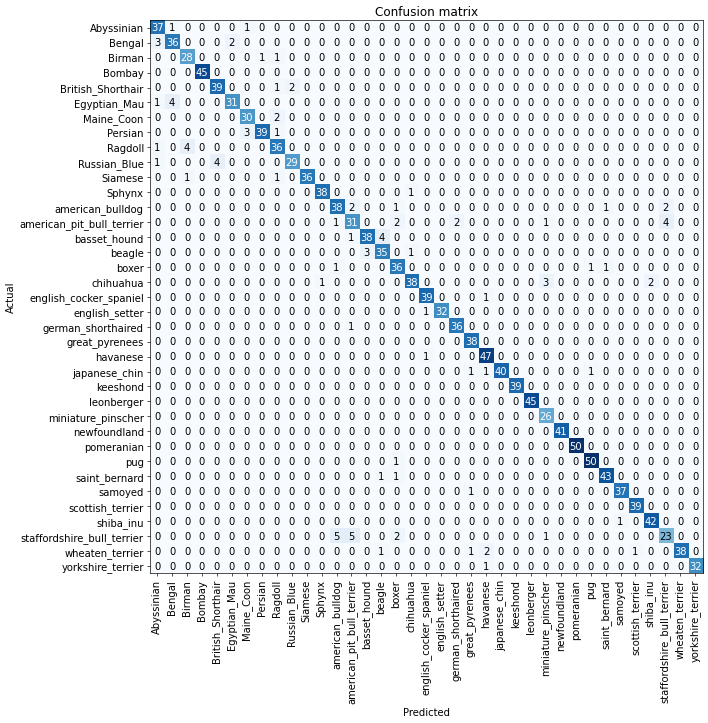

In [ ]:
#@ First using confusion matrix:

interp= ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
##@ Woah! the confusion matrix is veryy hard to read
##! Instead using the most_confused to get the most incorrect predictions
interp.most_confused(min_val=4)

[('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Ragdoll', 'Birman', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('basset_hound', 'beagle', 4)]

### Mastering Model Training with Learning Rate Optimization

One of the easiest ways to supercharge your model's performance is by carefully choosing the learning rate. It’s a delicate balance: set it too low, and you’ll waste epochs; crank it too high, and your model might diverge wildly.

Let’s break down the essentials:

##### 1. The Learning Rate Finder: A Game-Changer

Invented in 2015 by Leslie Smith, the Learning Rate Finder solves a critical issue in deep learning: finding the "Goldilocks" learning rate—not too high, not too low.

The approach? Gradually increase the learning rate during training and observe its impact on the loss.

##### 2. Why It Works


- **Low Learning Rate**: Model trains excruciatingly slowly, risks overfitting.
- **High Learning Rate**: Loss skyrockets as the optimizer overshoots the minimum.

By systematically increasing the rate, you can pinpoint the sweet spot—where the loss is decreasing steadily without spiking.

##### 3. How to Use It

SuggestedLRs(valley=0.0010000000474974513)

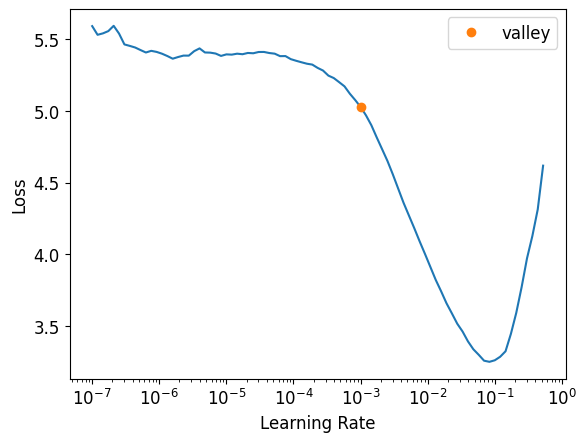

In [ ]:
#@ Here’s the fastai workflow:

'''
  1. Run the learning rate finder
'''

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

  2. Select the learning Rate:
  - Use a rate slightly below the minimum loss or where the loss starts decreasing steadily.
  - For instance, 3e-3 could work well here.

In [ ]:
'''
  3. Fine- Tune with the choosen learning rate:
'''

learn.fine_tune(2, base_lr= 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.306392,0.296461,0.093369,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.538488,0.379003,0.100135,01:15
1,0.327954,0.232102,0.068336,01:12


##### 4. Visualizing the Learning Rate

The plot of the learning rate versus loss often has a logarithmic scale, emphasizing the order of magnitude. Look for:

- The minimum loss.
- A region where the loss decreases steadily.

##### 5. Why It’s Revolutionary

The brilliance of Smith's discovery lies in its simplicity. Despite decades of neural network research, a practical, accessible solution like this only emerged recently. And you don’t need fancy tools or vast datasets—just curiosity and persistence.

So yeah, With the right learning rate locked in, you're ready to fine-tune pretrained models and take the training to the next level!